In [17]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import glob
import os
import matplotlib.pyplot as plt

In [2]:
csv_files = glob.glob("../data/raw/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    if symbol in ['BF.B','BRK.B','CTLT']:
        continue
    df = pd.read_csv(file, index_col=0 )

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0
    dfs[symbol] = df

In [24]:
returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()})

In [25]:
expected_returns = returns_df.copy().shift(-1)
#expected_returns.loc[:, :] = 0.0
#expected_volatility = returns_df.copy()
expected_volatility = returns_df.rolling(252).std() * np.sqrt(252)
score_df = expected_returns / expected_volatility
position = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
for i in trange(len(returns_df)):
    if i < 252:
        continue
    score = score_df.iloc[i]
    score = score[score > 0].sort_values(ascending=False)
    num_stocks = int(np.ceil(len(score) * 0.2))
    selected_stocks = score.index[:num_stocks]
    position.iloc[i, :] = 0.0
    if len(selected_stocks) > 0:
        position.loc[returns_df.index[i], selected_stocks] = 1.0 / num_stocks

  0%|          | 0/5287 [00:00<?, ?it/s]

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy_with_costs(weights: pd.DataFrame, 
                                 returns_df: pd.DataFrame, 
                                 cost_rate: float = 0.001, 
                                 rf: float = 0.0):
    """
    Backtest a strategy including transaction costs.
    
    Parameters
    ----------
    weights : pd.DataFrame
        Daily target weights (index: dates, columns: tickers).
    returns_df : pd.DataFrame
        Daily returns DataFrame (same shape as weights).
    cost_rate : float
        Proportional transaction cost per unit turnover (e.g., 0.001 = 0.1%).
    rf : float
        Annual risk-free rate for Sharpe ratio calculation.
        
    Returns
    -------
    net_returns : pd.Series
        Daily net returns after costs.
    cumulative_returns : pd.Series
        Cumulative net returns.
    metrics : dict
        Performance metrics: annual_return, annual_volatility, sharpe_ratio, max_drawdown.
    """
    raw_returns = (weights * returns_df).sum(axis=1)
    turnover = weights.diff().abs().sum(axis=1)
    turnover.iloc[0] = weights.iloc[0].abs().sum()
    costs = turnover * cost_rate
    net_returns = raw_returns - costs
    cumulative_returns = (1 + net_returns).cumprod()
    
    # Metrics
    n_days = net_returns.shape[0]
    total_return = cumulative_returns.iloc[-1]
    annual_return = total_return ** (252 / n_days) - 1
    annual_volatility = net_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - rf) / annual_volatility if annual_volatility != 0 else np.nan
    
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / running_max - 1
    max_drawdown = drawdown.min()
    
    metrics = {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }
    
    # Visualization
    plt.figure()
    cumulative_returns.plot(title='Cumulative Returns (Net of Costs)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

    plt.figure()
    drawdown.plot(title='Drawdown (Net of Costs)')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)
    plt.show()
    
    return net_returns, cumulative_returns, metrics





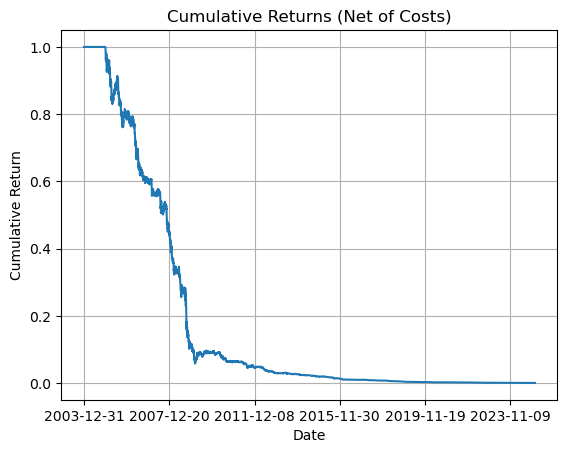

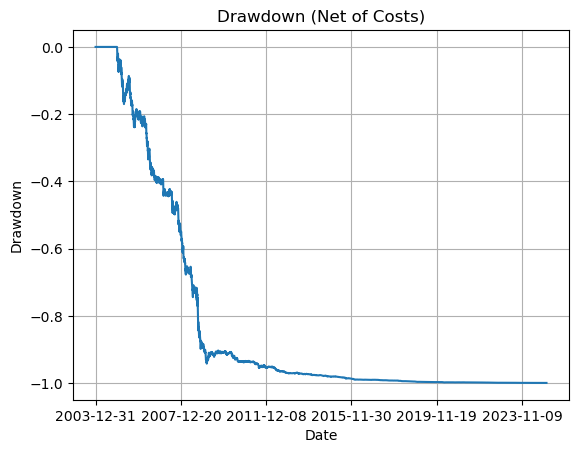

{'annual_return': -0.31092863058304676, 'annual_volatility': 0.2306401691736539, 'sharpe_ratio': -1.3481113532696984, 'max_drawdown': -0.9995976687679541}


In [27]:
net_ret, cum_ret, perf_metrics = backtest_strategy_with_costs(position, returns_df, cost_rate=0.001)
print(perf_metrics)